# Capstone Project - Battle of Neighborhoods
#### Using Foursquare API and California housing dataset: Sergiu Pod
---

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Results](#results)
* [Discussion](#discussion)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>
In this project we seek to **examine trends/popularity in local venues for city blocks of various median home values** in the San Francisco bay area. We hope to reveal a set of differentiating venue charecteristics, and believe this information would be **extremely relevant to corporations looking to establish a new headquarters, real estate investors as well as developers** looking to expand and invest in the bay area. 

## Data <a name="data"></a>
* In 1990 the **US Census Bureau collected roughly 20,000 blocks worth of housing data in the state of California,** complete with location information, median house value as well as data on the number of rooms in the houses. 
* We will also use the **Foursquare API in conjunction with the housing dataset** to collect information on local venues surrounding the housing blocks.

In [110]:
import numpy as np
import pandas as pd
import folium
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from keys import ID, SECRET

pd.set_option('display.width', None)

### Import the data
---
View data shape, feature categories, and target category. Then compute basic descriptive statistics.

In [111]:
cali = fetch_california_housing()
print(cali.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

**Note** that even though the homes might not sell for the same price that they did in 1990, we can still successfully cluster them based off of median home value since they likely appreciated somewhat uniformly, the blocks haven't moved around since then, and **we care more about what the neighborhoods have to offer.**

In [112]:
print(cali.data.shape)
cali.feature_names

(20640, 8)


['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

In [113]:
# house value measured in millions
cali.target

array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894])

In [114]:
data = pd.DataFrame(cali.data, columns=cali.feature_names)
data['MedHouseVal'] = pd.Series(cali.target)
data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [115]:
data.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


## Methodology <a name="methodology"></a>
### Visualizing information
---
We begin our data exploration by plotting the various categories against medHouseVal.

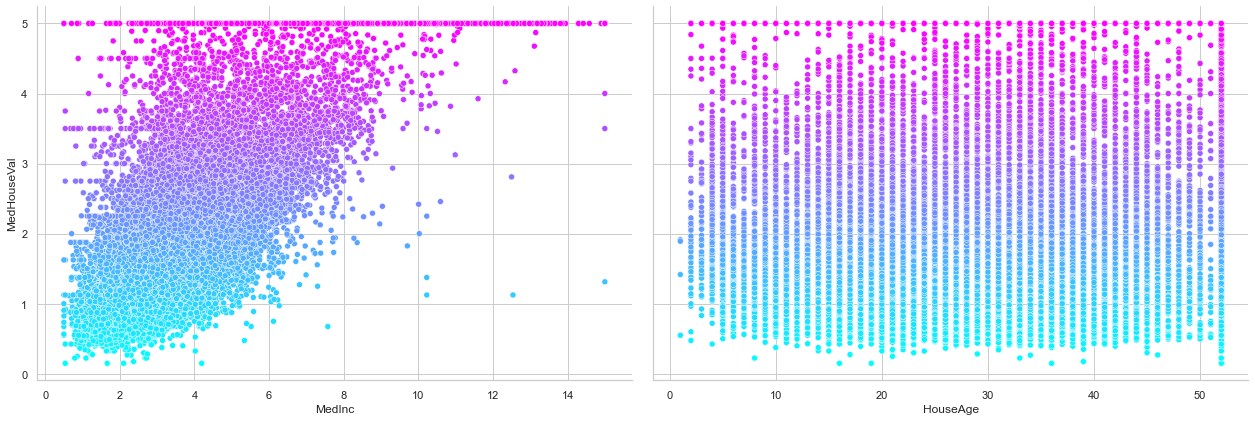

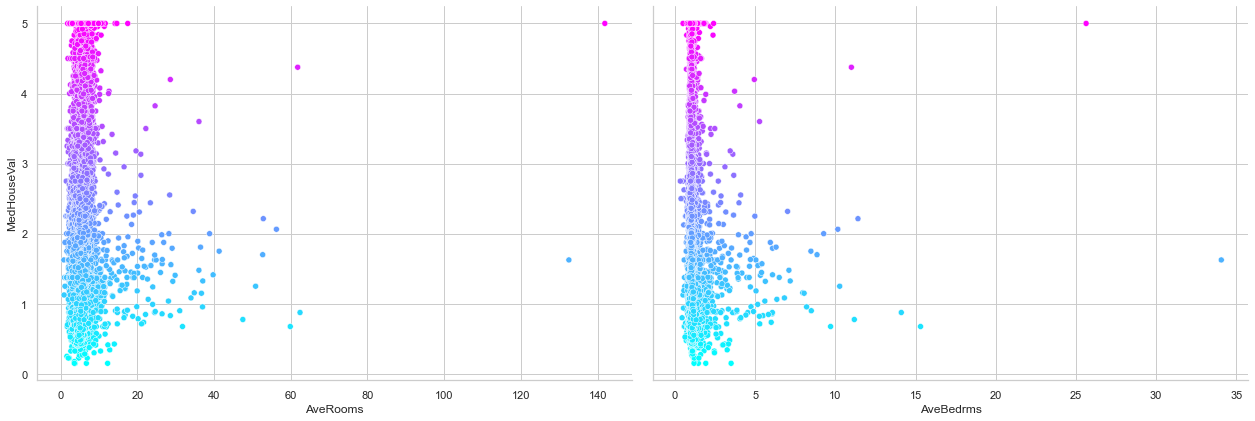

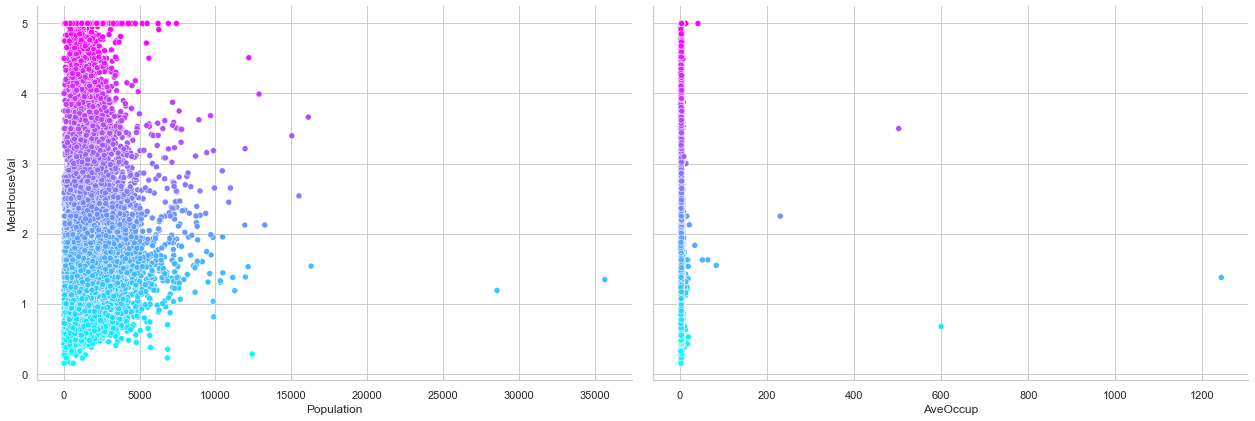

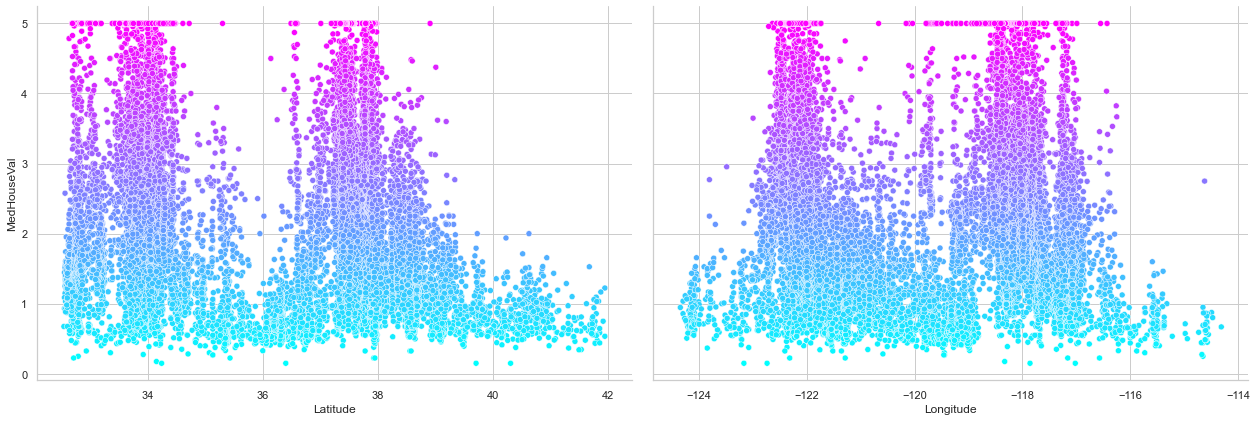

In [116]:
sns.set_theme(style='whitegrid', font_scale=1)
index = [('MedInc','HouseAge'),('AveRooms','AveBedrms'),('Population','AveOccup'),('Latitude','Longitude')]

for tup in index:
    grid = sns.PairGrid(data=data, y_vars='MedHouseVal', hue='MedHouseVal', palette='cool', x_vars=[i for i in tup], height=6, aspect = 1.5)
    grid.map(sns.scatterplot)
    #grid.savefig(f'{tup}.png', dpi=200, format='png')

### Filter data and binning operations
---
Here we **filter the data points capped at 500k** (the upper limit of medHouseVal) in order to remove outliers that could skew our results. We also will drop HouseAge, Population, and AveOccup since binning by them wouldn't help us too much.

In [117]:
# filter homes with median value of 5 mill
data.drop(index=data[data.loc[:,'MedHouseVal'] > 4.995].index, inplace=True)

# drop house age from dataset
data.drop(columns='HouseAge', inplace=True)

# drop population from dataset
data.drop(columns='Population', inplace=True)

# drop occupancy from dataset
data.drop(columns='AveOccup', inplace=True)

# rest index
data.reset_index(drop=True, inplace=True)

Now we will **bin our data according to median home value and then according to average number of rooms.** This will allow us to isolate similar sized homes where the main differentiating factor is the median value of the block.

In [118]:
# bin according to home value
homeValue = [0,1,2,3,4,5]
homeLabel = ['<100k', '1-200k', '2-300k', '3-400k', '4-500k']
data['Class'] = pd.cut(data['MedHouseVal'], bins=homeValue, labels=homeLabel)

In [119]:
# bin according to house size
homeRooms = [0,5,10,15,20,25]
homeLabel = ['<5','5-10','10-15','15-20','20-25']
data['Rooms'] = pd.cut(data['AveRooms'], bins=homeRooms, labels=homeLabel)

In [120]:
# filter for homes in the bay area
lat_bounds = [37.889161,37.214144]
lng_bounds = [-122.633508,-121.616997]

# filter by Latitude
data = data.loc[data['Latitude'] < lat_bounds[0]]
data = data.loc[data['Latitude'] > lat_bounds[1]]

# filter by Longitude
data = data.loc[data['Longitude'] > lng_bounds[0]]
data = data.loc[data['Longitude'] < lng_bounds[1]]

Right, so we've just eliminated a couple thousand values from our data set, that said we still have a statistically significant pool of information and everything looks good. Notice how there isn't a cap at 500k anymore.

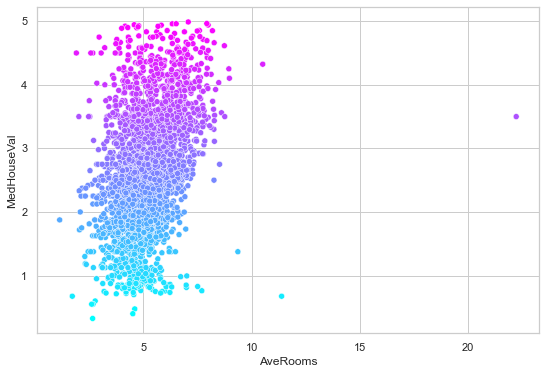

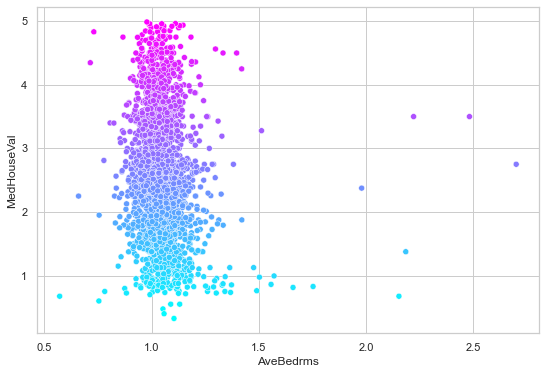

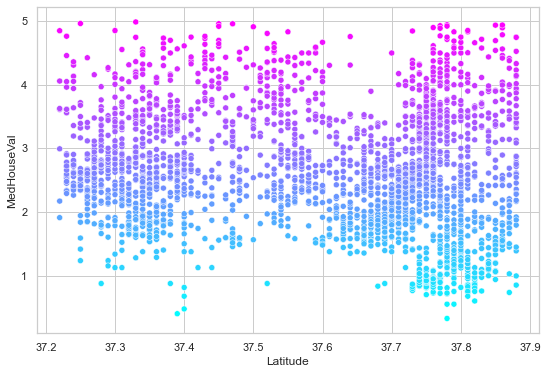

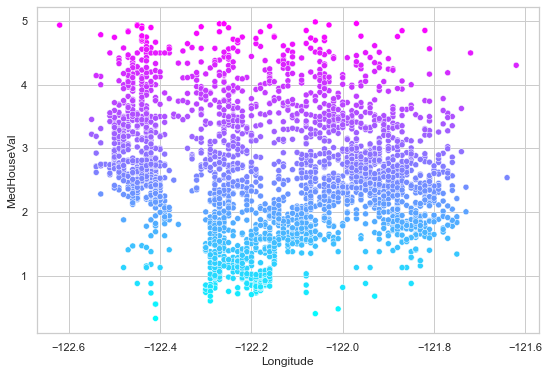

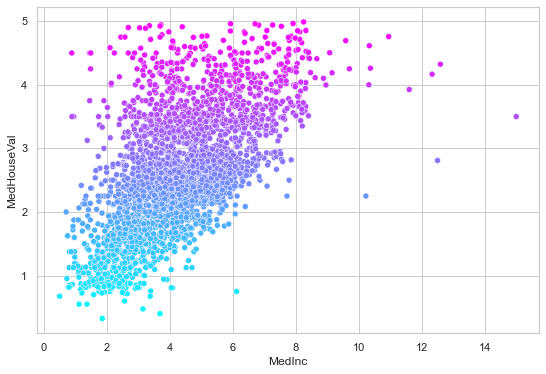

In [121]:
index = ['AveRooms','AveBedrms','Latitude','Longitude','MedInc']

for i in index:
    plt.figure(figsize=(9,6))
    sns.scatterplot(data=data, y='MedHouseVal', x=i, legend=False, hue='MedHouseVal', palette='cool')
    #plt.savefig(f'bay_{i}.png', dpi=200, format='png')
    plt.show()

### Obtain quality random sample from what's left
---
Let's take a random sample of 100 homes with 5-10 rooms from every class and map the results. **Notice** there are **only 37 data points representing blocks in the '<100k' home value class,** we'll just have to use all the information as there isn't enough to collect a random sample. We can use folium to visualize the sample on a map.

In [122]:
data.pivot_table(index=['Class','Rooms'], values=['MedInc'], aggfunc='count')

MedInc
Class  Rooms        
<100k  <5       78.0
       5-10     37.0
       10-15     1.0
1-200k <5      432.0
       5-10    207.0
2-300k <5      492.0
       5-10    627.0
3-400k <5      201.0
       5-10    426.0
       20-25     1.0
4-500k <5       70.0
       5-10    173.0
       10-15     1.0

In [123]:
# create map of SF
cali_map = folium.Map(location=[37.57075, -122.202028], tiles='Stamen toner',zoom_start=9)

#set color scale
scale = {'<100k':'#E63946','1-200k':'#F1FAEE','2-300k':'#A8DADC','3-400k':'#457B9D','4-500k':'#1D3557'}

# take representative sample
sample = data[data['Class'] == '<100k']
sample = sample[sample['Rooms'] == '5-10']

for i in ['1-200k', '2-300k', '3-400k', '4-500k']:
    temp = data[data['Class'] == i]
    temp = temp[temp['Rooms'] == '5-10']
    sample = sample.append((temp.sample(n=100, axis=0, random_state=7)), ignore_index=True)

#let's view our sample
for i in scale:
    rows = sample[sample['Class'] == i].index
    for lat, lng in zip(sample.loc[rows, 'Latitude'], sample.loc[rows, 'Longitude']):
        folium.CircleMarker(
            [lat, lng],
            radius=3,
            color=scale[i],
            fill=True,
            fill_opacity=0.5,
            parse_html=False).add_to(cali_map) 
    
cali_map

In [124]:
print(sample.shape)
sample.pivot_table(index=['Class','Rooms'], values=['MedInc'], aggfunc='count')

(437, 8)


,,MedInc
Class,Rooms,
<100k,5-10,37.0
1-200k,5-10,100.0
2-300k,5-10,100.0
3-400k,5-10,100.0
4-500k,5-10,100.0


### Foursquare API
---
Using the foursquare API, we'll collect venue information on all homes in our sample and get a sense of what venues surround different classes of homes.

In [125]:
def getNearbyVenues(homeClass, lat, lng):
    count = 1
    venues_list=[]
    for homeClass, lat, lng in zip(homeClass, lat, lng):           
        try:
            url = f'https://api.foursquare.com/v2/venues/explore?&client_id={ID}&client_secret={SECRET}&v={V}&ll={lat},{lng}&radius=2000&limit=100'
            results = requests.get(url).json()["response"]['groups'][0]['items']

            venues_list.append([(
                homeClass, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])
            print(f'Home {count}: success', end='\r')
            count += 1
        
        except KeyError as Error:
            print(Error,count)

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Class', 'Home Latitude', 'Home Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']
    
    return(nearby_venues)

In [126]:
V = '20210101'
temp = getNearbyVenues(sample['Class'], sample['Latitude'], sample['Longitude'])

In [127]:
venue = temp
venue.shape

(33503, 7)

In [128]:
# one hot encoding
onehot = pd.get_dummies(venue[['Venue Category']], prefix="", prefix_sep="")

# add class column back to dataframe
onehot['Class'] = venue['Class'] 

# move class column to the first column
fixed_columns = [onehot.columns[-1]] + list(onehot.columns[:-1])
onehot = onehot[fixed_columns]

onehot.head()

,Class,ATM,Accessories Store,Acupuncturist,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,...,Windmill,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio,Zoo,Zoo Exhibit
0,<100k,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,<100k,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,<100k,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,<100k,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,<100k,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [131]:
grouped = onehot.groupby('Class').sum().reset_index().T
grouped.columns = grouped.loc['Class']
grouped = grouped.iloc[1:,]
grouped = grouped[['<100k', '1-200k', '2-300k', '3-400k', '4-500k']]
grouped.head()

Class,<100k,1-200k,2-300k,3-400k,4-500k
ATM,0,18,22,26,19
Accessories Store,0,8,9,3,6
Acupuncturist,0,1,3,2,0
Adult Boutique,0,0,0,1,3
Afghan Restaurant,0,7,6,4,5


## Results <a name="results"></a>
Some immediate takeaways from visualizing our findings are:
* Outside of fast food restaurants, convenience stores, bars, and liquor stores, **there is little variety in venue options for <100k dollar housing blocks** in the bay area
* As the value of the housing blocks increases, **we see an increase in venue variety** represented by the number of unique establishments, amenities, and recreational areas
* Homes valued at between **3-500k command the most access to outdoor recreational areas,** this suggests that home owners value access to natural and geographic features
### Visualizing the findings
---
Let's use seaborn to visualize the different clusters.

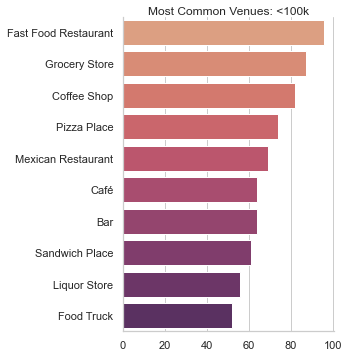

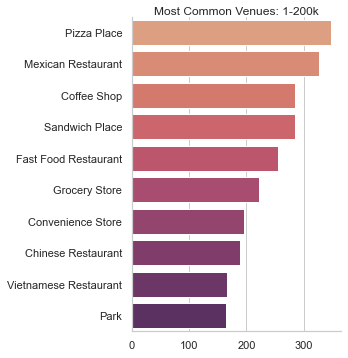

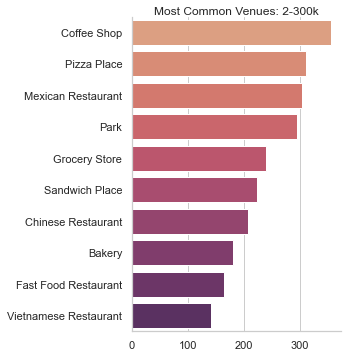

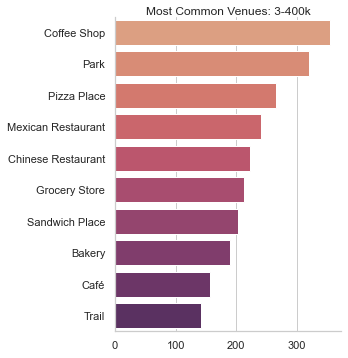

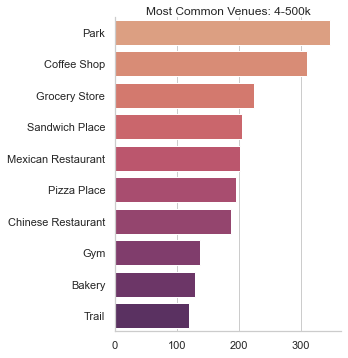

In [132]:
for i in grouped.columns:
    bars = grouped[[i]].sort_values(i, ascending=False).head(10)
    sns.catplot(data=bars, y=bars.index, x=bars[i].values, kind='bar', palette='flare')
    plt.title(f'Most Common Venues: {i}', pad=2)
    
    if i == '<100k':
        plt.savefig(f'venue_100k.png', dpi=200, format='png')
    else:
        plt.savefig(f'venue_{i}.png', dpi=200, format='png')
    plt.show()

## Discussion  <a name="discussion"></a>
In general, as the **value of the homes in the various blocks increased, we noticed that the number of unique venues increased as well.** Fast food restaurants, liquor stores, and bars were replaced with japanese, chinese, pizza places, and cafes. Not only that, but access to recreational areas like trails and parks also increased, suggesting that **the kinds of individuals you can expect to find in the more expensive blocks value work life balance and wellness.** This leads to the following recommendations for any prospecting real estate developers/investors:
* Prioritize locations with a large variety of unique venue options and things to do as this can drive up median home value for a block
* Locations that offer great work life balance, with routine access to trails and parks, are valued higher than locations offering limited access to the local geography
* Locations offering access to more amenities like gyms, grocery stores, and cafes cater well to the active lifestyles of aspiring professionals, prioritizing wellness, and tend to fetch a premium

## Conclusion <a name="conclusion"></a>
By utilizing the Foursquare API along with the US Census California Housing Data Set, we were able to identify the differentiating venue charecteristics in various clusters of homes in the bay area. With an understanding of what types of venues concentrate around differently valued clusters of homes, real estate developers and investers may now make highly informed decisions, building and investing with confidence.